In [1]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.types import Command, interrupt
import os

# store conversation in memory checkpoints. Uses RAM by default.
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_core.tools import tool

from langgraph.store.postgres import PostgresStore
from langgraph.store.sqlite import SqliteStore

import re

BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"
EMBEDDING_MODEL = 'nomic-embed-text'

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class AgentState(TypedDict):
    messages : Annotated[list, operator.add]
    

In [4]:
# Transfer money tool

@tool
def transfer_money(amount:int, recipient:str):
    """
    Transfer money. Larger transfers require approval.

    Args:
        amount: Amount in dollars
        recipient: Recipient name
    """

    # Let's ask for user approval is amount is greater than $1000
    if amount > 1000:
        approval = interrupt({
            "type": "approval_required",
            "amount": amount,
            "recipient": recipient
        })

        if approval.get("decision") != "approve":
            return "Transfer is cancelled !"
    
    return f"Transferred ${amount} to {recipient} successfully!"

In [5]:
transfer_money.invoke({'amount':100,'recipient':'Mehran'})

'Transferred $100 to Mehran successfully!'

In [6]:
## Guardrail node

patterns = {
        "SSN": r'\b\d{3}-\d{2}-\d{4}\b',  # SSN: 123-45-6789
        "Credit Card": r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b',  # Credit Card: 1234-5678-9012-3456
        "Mobile Number": r'\b(\+?\d{1,3}[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}\b',  # Mobile: +1-234-567-8900
        "Email": r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',  # Email: user@example.com
        "URL/Link": r'https?://[^\s]+|www\.[^\s]+'  # URL: http://example.com or www.example.com
    }

def guardrail_node(state: AgentState):
    last_message = state["messages"][-1].content

    for pii_type, pattern in patterns.items():
        if re.search(pattern, last_message):
            return {
                "messages": [
                    SystemMessage(f"Request Blocked: Contains {pii_type}. Please don't share sensitive personal information")
                ]
            }

    return {"messages": []}

In [7]:
## Agent node

def agent_node(state: AgentState):
    
    tools = [transfer_money]

    llm_with_tools = llm.bind_tools(tools)

    system_message = SystemMessage("You are financial assistant. Use transfer_money tool to transfer money.")

    messages = [system_message] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool: {tc.get('name','?')} with args: {tc.get('args','?')}")
    else:
        print(f"[AGENT] Responding ...")

    return {'messages': [response]}

In [8]:
## Conditional Edges - guardrail and agent


def should_continue(state: AgentState):
    last = state['messages'][-1]

    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return END
    
def guardrail_router(state: AgentState):
    last = state['messages'][-1]

    if isinstance(last, SystemMessage):
        last.pretty_print()
        return END
    else:
        return "agent"


In [9]:
## DB setup

import os
import sqlite3

db_name = "db/checkpoint.db"
# if os.path.exists(db_name):
#     os.removedirs(db_name)


os.makedirs('db', exist_ok=True)



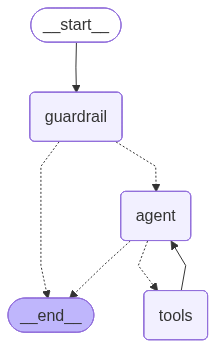

In [10]:
## Graph Construction

def create_agent():
    builder = StateGraph(AgentState)

    #add all nodes
    builder.add_node("guardrail", guardrail_node)
    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode([transfer_money]))

    builder.add_edge(START, "guardrail")
    builder.add_conditional_edges("guardrail", guardrail_router, ['agent', END])
    builder.add_conditional_edges("agent", should_continue, ['tools', END])

    builder.add_edge("tools", "agent")

    conn= sqlite3.connect(db_name, check_same_thread=False)
    checkpointer = SqliteSaver(conn)

    graph = builder.compile(checkpointer=checkpointer)

    return graph

agent = create_agent()
agent

In [ ]:
## Demo 1 : Small Transfer (No Interrupt)

config = {"configurable":{'thread_id': 'demo-1'}}

query = "Transfer 500 to mehran"
result = agent.invoke({'messages': [HumanMessage(query)]}, config)
result

[AGENT] called Tool: transfer_money with args: {'amount': 500, 'recipient': 'mehran'}
[AGENT] Responding ...


{'messages': [HumanMessage(content='Transfer 500 to mehran', additional_kwargs={}, response_metadata={}),
  AIMessage(content="<think>\nOkay, the user wants to transfer 500 dollars to someone named mehran. Let me check the tools available. There's a transfer_money function that requires amount and recipient. The amount is 500, which is an integer, and the recipient is mehran. Since the function doesn't mention any other parameters, I just need to pass these two. I should make sure the amount is in the correct format and the recipient's name is properly spelled. No other steps are needed here. Let me structure the tool call accordingly.\n</think>\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2026-01-10T16:49:04.125835Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17355794417, 'load_duration': 5273860333, 'prompt_eval_count': 189, 'prompt_eval_duration': 3502151958, 'eval_count': 144, 'eval_duration': 8511977958, 'logprobs': None, 'model_name

In [16]:
## Demo 2 :  Large Transfer (Approval required)

query = "Transfer 5000 to mehran"
result = agent.invoke({'messages': [HumanMessage(query)]}, config)
result

[AGENT] called Tool: transfer_money with args: {'amount': 5000, 'recipient': 'mehran'}


{'messages': [HumanMessage(content='Transfer 500 to mehran', additional_kwargs={}, response_metadata={}),
  AIMessage(content="<think>\nOkay, the user wants to transfer 500 dollars to someone named mehran. Let me check the tools available. There's a transfer_money function that requires amount and recipient. The amount is 500, which is an integer, and the recipient is mehran. Since the function doesn't mention any other parameters, I just need to pass these two. I should make sure the amount is in the correct format and the recipient's name is properly spelled. No other steps are needed here. Let me structure the tool call accordingly.\n</think>\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2026-01-10T16:49:04.125835Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17355794417, 'load_duration': 5273860333, 'prompt_eval_count': 189, 'prompt_eval_duration': 3502151958, 'eval_count': 144, 'eval_duration': 8511977958, 'logprobs': None, 'model_name

In [17]:
if '__interrupt__' in result:
    interrupt_data = result['__interrupt__'][0]
    result = agent.invoke(
        Command(resume ={'decision': input('do you approve or reject it?')}),
        config 
    )

    result['messages'][-1].pretty_print()

[AGENT] Responding ...
================================== Ai Message ==================================

<think>
Okay, the user tried to transfer 5000 to mehran again, but the system canceled the transfer. Let me check why. The previous transfers were successful, so maybe the cancellation is due to a new rule or a system error. The user might be confused why it's being canceled. I should inform them that the transfer was canceled and ask if they want to try again or need help with something else. Also, maybe there's a limit on the amount, but the function didn't mention that. Alternatively, it could be a duplicate transaction. I need to respond clearly and offer assistance.
</think>

The transfer of $5000 to mehran has been canceled. Would you like to attempt the transfer again or need assistance with something else?


In [18]:
def chat(query, thread_id):
    config = {"configurable":{'thread_id': thread_id}}
    result = agent.invoke({'messages': [HumanMessage(query)]}, config)
    if '__interrupt__' in result:
        interrupt_data = result['__interrupt__'][0]
        result = agent.invoke(
            Command(resume ={'decision': input('do you approve or reject it?')}),
            config 
        )

    result['messages'][-1].pretty_print()

In [19]:
query = "Transfer 5000 to mehran"
thread_id = "demo-3"

chat(query, thread_id)

[AGENT] called Tool: transfer_money with args: {'amount': 5000, 'recipient': 'mehran'}
[AGENT] Responding ...
================================== Ai Message ==================================

<think>
</think>

The transfer of $5000 to mehran has been completed successfully! Let me know if you need further assistance.


## Guardrail Tests

In [20]:
query = "Transfer 5000 to mehranabul@gmail.com"
thread_id = "demo-3"

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains Email. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains Email. Please don't share sensitive personal information


In [21]:
query = "Transfer 5000 to card 1234-5678-9012-3456"
thread_id = "demo-3"

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains Credit Card. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains Credit Card. Please don't share sensitive personal information


In [22]:
query = "Transfer 5000 to mehran and send receipt to https://example.com/receipt"
thread_id = "demo-3"

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains URL/Link. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains URL/Link. Please don't share sensitive personal information


In [23]:
query = "Transfer 5000 to mehran and send receipt to +1-234-567-8900"
thread_id = "demo-3"

chat(query, thread_id)

================================ System Message ================================

Request Blocked: Contains Mobile Number. Please don't share sensitive personal information
================================ System Message ================================

Request Blocked: Contains Mobile Number. Please don't share sensitive personal information
